This python book will look to predict values of missing values within a pcap before using a model to predict quality resolution. This is compared to the status quo of using the method of dropping values which can be found in our Baseline Netflix IPYNB notebook. 

We will start by taking a pcap file and inducing NaN values in the window size feature column. The reason we want to do this is by artificially creating NaN values so that in the future our model is able to predict these values. 

In [2]:
from scapy.all import rdpcap, wrpcap, TCP
import random
import pandas as pd

# Read the original pcap file
packets = rdpcap('data/netflix_resolution.pcap')

# Set parameters
nan_percentage = 0.3  # 30% of TCP packets will have window set to 0 (representing NaN)
random.seed(42)  # For reproducibility

# Track statistics
tcp_count = 0
modified_count = 0
original_windows = []
modified_windows = []

# Process packets
for packet in packets:
    if packet.haslayer(TCP):
        tcp_count += 1
        original_window = packet[TCP].window
        original_windows.append(original_window)
        
        # Randomly decide if this packet should have NaN window
        if random.random() < nan_percentage:
            packet[TCP].window = 0  # Set to 0 to represent NaN
            modified_count += 1
            modified_windows.append(None)  # Track as NaN
        else:
            modified_windows.append(original_window)
        
        # Recalculate checksums after modification
        del packet[TCP].chksum
        packet = packet.__class__(bytes(packet))

# Save modified pcap file
output_file = 'data/netflix_resolution_nan_window.pcap'
wrpcap(output_file, packets)

# Print statistics
print(f"Total packets: {len(packets)}")
print(f"TCP packets: {tcp_count}")
print(f"Modified packets (NaN induced): {modified_count}")
print(f"Percentage modified: {modified_count/tcp_count*100:.2f}%")
print(f"\nOriginal window size stats:")
print(f"  Min: {min([w for w in original_windows if w > 0])}")
print(f"  Max: {max(original_windows)}")
print(f"  Mean: {sum(original_windows)/len(original_windows):.2f}")
print(f"\nModified pcap saved to: {output_file}")

Total packets: 84440
TCP packets: 77999
Modified packets (NaN induced): 23360
Percentage modified: 29.95%

Original window size stats:
  Min: 1
  Max: 65535
  Mean: 2374.05

Modified pcap saved to: data/netflix_resolution_nan_window.pcap


Great, now we actually want a model to predict these values in the first place. We need to make sure that we are not using our current pcap in this training data as that will cause model leakage. Therefore, we will use another netflix pcap to build a model to predict the values. 

In [3]:
from scapy.all import rdpcap, TCP, IP, IPv6
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Read the training pcap file
print("Reading pcap file...")
packets = rdpcap('data/netflix_traffic_unlabeled.pcap')

# Extract features from packets
data = []
for packet in packets:
    if packet.haslayer(TCP):
        tcp = packet[TCP]
        
        # Extract features
        features = {
            'src_port': tcp.sport,
            'dst_port': tcp.dport,
            'seq': tcp.seq,
            'ack': tcp.ack,
            'flags': int(tcp.flags),
            'window': tcp.window,  # Target variable
        }
        
        # Add IP layer features
        if packet.haslayer(IP):
            features['ttl'] = packet[IP].ttl
            features['packet_len'] = packet[IP].len
        elif packet.haslayer(IPv6):
            features['ttl'] = packet[IPv6].hlim
            features['packet_len'] = packet[IPv6].plen
        else:
            continue
            
        data.append(features)

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nTotal TCP packets extracted: {len(df)}")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Remove rows where window is 0 (if any exist as outliers)
df_clean = df[df['window'] > 0].copy()
print(f"\nCleaned data shape: {df_clean.shape}")

# Separate features and target
X = df_clean.drop('window', axis=1)
y = df_clean['window']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train Random Forest model
print("\nTraining Random Forest model...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(feature_importance)

# Save the model
model_path = 'data/window_size_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"\nModel saved to: {model_path}")

# Show some example predictions
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10].astype(int),
    'Difference': (y_test.values[:10] - y_pred[:10]).astype(int)
})
print(comparison)

Reading pcap file...

Total TCP packets extracted: 54415

DataFrame shape: (54415, 8)

First few rows:
   src_port  dst_port         seq         ack  flags  window  ttl  packet_len
0     63975       443  3832097768  3759796888     24      45   64          68
1       443     63975  3759796888  3832097804     16      32   49          32
2       443     63975  3759796888  3832097804     24      32   49          79
3     63975       443  3832097804  3759796935     16      45   64          32
4     63975       443  3832097804  3759796935     24      45   64          67

Cleaned data shape: (54400, 8)

Training set size: 43520
Test set size: 10880

Training Random Forest model...

MODEL PERFORMANCE
Mean Squared Error: 281179.82
Root Mean Squared Error: 530.26
Mean Absolute Error: 32.45
R² Score: 0.9971

FEATURE IMPORTANCE
      feature  importance
0    src_port    0.751785
2         seq    0.145023
3         ack    0.072272
4       flags    0.022542
6  packet_len    0.004901
5         ttl   

Now that we have a model to predict these values (specifically window size), I can use this model to predict the missing values that are NaN. WARNING: Will take quite some time to load as it needs to predict each missing value (close to 20-25 min)

In [4]:
from scapy.all import rdpcap, wrpcap, TCP, IP, IPv6
import pandas as pd
import pickle
import numpy as np

# Load the trained model
print("Loading trained model...")
with open('data/window_size_model.pkl', 'rb') as f:
    model = pickle.load(f)
print("Model loaded successfully!")

# Read the pcap file with NaN windows
print("\nReading pcap file with NaN windows...")
packets = rdpcap('data/netflix_resolution_nan_window.pcap')

# Track statistics
total_packets = len(packets)
tcp_packets = 0
nan_windows = 0
predicted_windows = 0

# Create a new list for corrected packets
corrected_packets = []

# Process each packet
for packet in packets:
    if packet.haslayer(TCP):
        tcp_packets += 1
        tcp = packet[TCP]
        
        # Check if window is 0 (our NaN indicator)
        if tcp.window == 0:
            nan_windows += 1
            
            # Extract features for prediction
            features = {
                'src_port': tcp.sport,
                'dst_port': tcp.dport,
                'seq': tcp.seq,
                'ack': tcp.ack,
                'flags': int(tcp.flags),
            }
            
            # Add IP layer features
            if packet.haslayer(IP):
                features['ttl'] = packet[IP].ttl
                features['packet_len'] = packet[IP].len
            elif packet.haslayer(IPv6):
                features['ttl'] = packet[IPv6].hlim
                features['packet_len'] = packet[IPv6].plen
            else:
                corrected_packets.append(packet)
                continue
            
            # Create DataFrame with features in correct order
            feature_df = pd.DataFrame([features])
            
            # Predict window size
            predicted_window = model.predict(feature_df)[0]
            predicted_window = int(max(1, predicted_window))  # Ensure it's at least 1
            
            # Update the packet
            packet[TCP].window = predicted_window
            predicted_windows += 1
            
            # Recalculate checksum
            del packet[TCP].chksum
            packet = packet.__class__(bytes(packet))
    
    # Add packet to corrected list
    corrected_packets.append(packet)

# Save the corrected pcap file
output_file = 'data/netflix_resolution_predicted_window.pcap'
wrpcap(output_file, corrected_packets)

# Print statistics
print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)
print(f"Total packets: {total_packets}")
print(f"TCP packets: {tcp_packets}")
print(f"Packets with NaN windows (window=0): {nan_windows}")
print(f"Windows successfully predicted: {predicted_windows}")
print(f"Percentage of TCP packets corrected: {predicted_windows/tcp_packets*100:.2f}%")
print(f"\nCorrected pcap saved to: {output_file}")

# Verify the corrections by reading back
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)
verified_packets = rdpcap(output_file)
zero_windows = sum(1 for p in verified_packets if p.haslayer(TCP) and p[TCP].window == 0)
print(f"Packets with window=0 in corrected file: {zero_windows}")
print(f"All NaN values filled: {'YES ✓' if zero_windows == 0 else 'NO ✗'}")

# Show some example predicted windows
print("\n" + "="*60)
print("SAMPLE PREDICTED WINDOWS")
print("="*60)
sample_windows = [p[TCP].window for p in verified_packets if p.haslayer(TCP)][:20]
print(f"First 20 window sizes in corrected file:")
print(sample_windows)

Loading trained model...
Model loaded successfully!

Reading pcap file with NaN windows...

PREDICTION RESULTS
Total packets: 84440
TCP packets: 77999
Packets with NaN windows (window=0): 23461
Windows successfully predicted: 23461
Percentage of TCP packets corrected: 30.08%

Corrected pcap saved to: data/netflix_resolution_predicted_window.pcap

VERIFICATION
Packets with window=0 in corrected file: 0
All NaN values filled: YES ✓

SAMPLE PREDICTED WINDOWS
First 20 window sizes in corrected file:
[1294, 284, 395, 395, 56, 56, 2739, 395, 2739, 395, 395, 2739, 395, 395, 56, 54, 883, 56, 56, 762]


Now below, we will follow the same methods as in the baseline prediciton model to predict our QoE inferencing to see if predicting with NaN values is allowed or not. 

In [5]:
## Import Netflix Pcap

from scapy.all import rdpcap, IP, IPv6, TCP, UDP, DNS
import pandas as pd

pkts = rdpcap("./data/netflix_resolution_predicted_window.pcap")
rows = []

for p in pkts:
    is_dns = DNS in p
    proto = "DNS" if is_dns else ("TCP" if TCP in p else ("UDP" if UDP in p else p.name))
    txid = p[DNS].id if is_dns else None
    
    # Get IP addresses - check both IPv4 and IPv6
    src_ip = None
    dst_ip = None
    
    if IPv6 in p:
        src_ip = p[IPv6].src
        dst_ip = p[IPv6].dst
    elif IP in p:
        src_ip = p[IP].src
        dst_ip = p[IP].dst
    
    rows.append({
        "timestamp": float(getattr(p, "time", None)),
        "length": len(p),
        "src_ip": src_ip,
        "dst_ip": dst_ip,
        "protocol": proto,
        "src_port": p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None),
        "dst_port": p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None),
        "txid": txid,
        "info": str(p.summary())
    })

nflx_pcap = pd.DataFrame(rows)

nflx_pcap.head()

,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
0,1.765427e+09,1081,10.0.0.154,224.0.0.251,DNS,5353.0,5353.0,0.0,"Ether / IP / UDP / DNS Ans ""[b'container_id={1..."
1,1.765427e+09,1101,fe80::c2e5:daff:fe92:5423,ff02::fb,DNS,5353.0,5353.0,0.0,"Ether / IPv6 / UDP / DNS Ans ""[b'container_id=..."
2,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64364.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
3,1.765510e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64370.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
4,1.765427e+09,173,10.0.0.246,224.0.0.251,DNS,5353.0,5353.0,0.0,"Ether / IP / UDP / DNS Qry ""b'_companion-link...."


In [6]:
## Get Netflix IPs via SNI from Pcap

import subprocess
import re

NETFLIX_KEYWORDS = [
    "netflix", "nflxvideo", "nflxso",
    "nflxext", "nflximg", "nflx"
]

def is_netflix_hostname(h):
    if not h:
        return False
    h = h.lower()
    return any(k in h for k in NETFLIX_KEYWORDS)


def extract_netflix_ips_tshark(pcap_file):

    # Extract SNI + IP from TLS Client Hello
    cmd = [
        r"C:\Program Files\Wireshark\tshark.exe",
        "-r", pcap_file,
        "-Y", "tls.handshake.extensions_server_name",
        "-T", "fields",
        "-e", "tls.handshake.extensions_server_name",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ipv6.src",
        "-e", "ipv6.dst",
    ]

    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    lines = result.stdout.splitlines()

    netflix_ips = set()

    for line in lines:
        fields = line.split("\t")

        # columns: SNI, ip.src, ip.dst, ipv6.src, ipv6.dst
        sni = fields[0] if len(fields) > 0 else ""
        ip4_src = fields[1] if len(fields) > 1 else ""
        ip4_dst = fields[2] if len(fields) > 2 else ""
        ip6_src = fields[3] if len(fields) > 3 else ""
        ip6_dst = fields[4] if len(fields) > 4 else ""

        if is_netflix_hostname(sni):

            # add all addresses
            for ip in (ip4_src, ip4_dst, ip6_src, ip6_dst):
                if ip:
                    netflix_ips.add(ip)

    return netflix_ips


netflix_ips = extract_netflix_ips_tshark("./data/netflix_resolution_predicted_window.pcap")

print("\n==============================")
print(" Netflix IP Addresses (SNI matched)")
print("==============================")

for ip in sorted(netflix_ips):
    print(ip)

print("\nTotal unique:", len(netflix_ips))


 Netflix IP Addresses (SNI matched)
2601:240:c484:b660:71e8:12b4:aa8c:c805
2a00:86c0:1034:1034::144
2a00:86c0:1034:1034::147
2a00:86c0:1034:1034::166
2a00:86c0:1035:1035::155
2a00:86c0:1035:1035::156
2a00:86c0:1035:1035::202
2a00:86c0:109:109:2::13
2a00:86c0:109:109:2::67
2a00:86c0:109:109:2::72
2a00:86c0:109:109::12b
2a00:86c0:109:109::251
2a03:5640:f502:80::81a0:1099
2a03:5640:f502:80::8834:17e
2a03:5640:f502:80::ee21:17e
2a03:5640:f502:82::d95:1099

Total unique: 16


In [7]:
## Get Netflix Packets

nflx_pkts = nflx_pcap[
    nflx_pcap['src_ip'].isin(netflix_ips) | 
    nflx_pcap['dst_ip'].isin(netflix_ips)
]

print(f"Total Netflix-related packets: {len(nflx_pkts)}")
print(f"Percentage of traffic: {len(nflx_pkts)/len(nflx_pcap)*100:.2f}%")

nflx_pkts.head()

Total Netflix-related packets: 78944
Percentage of traffic: 93.49%


,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
2,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64364.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
3,1.765510e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64370.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
8,1.765510e+09,330,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a03:5640:f502:82::8834:17e,TCP,63216.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
9,1.765510e+09,125,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a03:5640:f502:82::8834:17e,TCP,63216.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
10,1.765427e+09,86,2a03:5640:f502:82::8834:17e,2601:240:c484:b660:71e8:12b4:aa8c:c805,TCP,443.0,63216.0,NaN,Ether / IPv6 / TCP 2a03:5640:f502:82::8834:17e...


In [8]:
## Create Netflix flows

import numpy as np

# Filter for tcp, udp traffic only
df = nflx_pkts.copy()
df = df[df["protocol"].fillna("").str.lower().isin(["tcp", "udp"])].reset_index(drop=True)

# Ensure timestamp and length numeric
df["timestamp"] = df["timestamp"].astype(float)
df["length"] = df["length"].astype(int)

# Compute 1-second time window (align to multiples of 1)
df["time_window"] = (np.floor(df["timestamp"] / 1) * 1).astype(int)

# Compute inter-arrival time for each packet
df['iat'] = df.groupby("time_window")["timestamp"].diff()


# Aggregate per time window
nflx_flows = df.groupby("time_window").agg(
    packet_count=("length", "size"),
    total_bytes=("length", "sum"),
    mean_pkt_size=("length", "mean"),
    max_pkt_size=("length", "max"),
    min_pkt_size=("length", "min"),
    unique_dst_ips=("dst_ip", "nunique"),
    pkt_size_std=('length', 'std'),
    pkt_size_median=('length', 'median'),
    pkt_size_sum=('length', 'sum'),
    pkt_size_25th=('length', lambda x: x.quantile(0.25)),
    pkt_size_75th=('length', lambda x: x.quantile(0.75)),
    # Inter-arrival time statistics
    iat_min=('iat', 'min'),
    iat_max=('iat', 'max'),
    iat_mean=('iat', 'mean'),
    iat_std=('iat', 'std'),
    iat_median=('iat', 'median'),
    iat_25th=('iat', lambda x: x.quantile(0.25)),
    iat_75th=('iat', lambda x: x.quantile(0.75)),
).reset_index()


# Show result
print("Per-window summary rows:", len(nflx_flows))
print("\nFlow features (first 10 windows):")
nflx_flows.head(10)

Per-window summary rows: 1706

Flow features (first 10 windows):


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,unique_dst_ips,pkt_size_std,pkt_size_median,pkt_size_sum,pkt_size_25th,pkt_size_75th,iat_min,iat_max,iat_mean,iat_std,iat_median,iat_25th,iat_75th
0,1765426684,1,86,86.000000,86,86,1,NaN,86.0,86,86.0,86.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1765426685,14,6990,499.285714,1514,86,3,666.114500,86.0,6990,86.0,1166.75,9.536743e-07,0.384236,0.051426,0.105467,0.004122,6.389618e-05,0.063457
2,1765426686,189,210573,1114.142857,1514,86,4,623.786785,1514.0,210573,326.0,1514.00,0.000000e+00,0.356711,0.004163,0.027490,0.000002,1.132488e-06,0.000091
3,1765426687,133,121831,916.022556,1514,86,6,660.881499,1474.0,121831,86.0,1514.00,0.000000e+00,0.146213,0.006162,0.019208,0.000011,9.536743e-07,0.001053
4,1765426688,229,171747,749.986900,1514,86,13,630.511547,535.0,171747,93.0,1514.00,0.000000e+00,0.202030,0.003104,0.015151,0.000008,1.907349e-06,0.000147
5,1765426689,220,187468,852.127273,1514,86,7,668.901268,954.0,187468,86.0,1514.00,0.000000e+00,0.114335,0.003070,0.012267,0.000008,9.536743e-07,0.000158
6,1765426690,290,339723,1171.458621,1514,86,8,576.016129,1514.0,339723,910.0,1514.00,0.000000e+00,0.197696,0.003253,0.016665,0.000002,9.536743e-07,0.000079
7,1765426691,129,155820,1207.906977,1514,86,5,545.661861,1514.0,155820,910.0,1514.00,0.000000e+00,0.136238,0.007437,0.024691,0.000002,9.536743e-07,0.000146
8,1765426692,189,197816,1046.645503,1514,86,8,637.048694,1514.0,197816,135.0,1514.00,0.000000e+00,0.135917,0.004401,0.013922,0.000003,1.192093e-06,0.000956
9,1765426693,412,403256,978.776699,1514,74,13,661.988940,1514.0,403256,86.0,1514.00,0.000000e+00,0.170441,0.002313,0.009931,0.000003,9.536743e-07,0.000710


In [9]:
## Get Resolution labels

labels_df = pd.read_csv("./data/netflix_resolution_labels.csv")

# Extract the specific columns and rename
labels_df = labels_df[['timestamp_ms', 'videoHeight']].copy()
labels_df = labels_df.rename(columns={'videoHeight': 'resolution'})

print(f"Labels shape: {labels_df.shape}")
print(f"\nColumns: {labels_df.columns.tolist()}")
print(f"\nFirst few rows:")
labels_df.head()

Labels shape: (467, 2)

Columns: ['timestamp_ms', 'resolution']

First few rows:


,timestamp_ms,resolution
0,1765426713257,270
1,1765426714260,270
2,1765426715258,270
3,1765426716258,270
4,1765426717259,270


In [10]:
# Convert timestamp_ms to seconds for matching with nflx_pkts
labels_df['timestamp_sec'] = (labels_df['timestamp_ms'] / 1000).astype(float)

# Create 1-second time window for labels (same logic as nflx_pkts)
labels_df['time_window'] = (np.floor(labels_df['timestamp_sec'] / 1) * 1).astype(int)

# Join labels onto nflx_flows based on time_window
nflx_flows_joined = nflx_flows.merge(
    labels_df[['time_window', 'resolution']], 
    on='time_window', 
    how='inner'
)

print(f"nflx_flows shape after join: {nflx_flows_joined.shape}")
print(f"\nFlows with resolution labels: {nflx_flows_joined['resolution'].notna().sum()}")
print(f"Flows without labels: {nflx_flows_joined['resolution'].isna().sum()}")
print(f"\nResolution distribution:")
print(nflx_flows_joined['resolution'].value_counts(dropna=False))

print(f"\nSample joined data:")
nflx_flows_joined.head(500)

nflx_flows shape after join: (450, 20)

Flows with resolution labels: 450
Flows without labels: 0

Resolution distribution:
resolution
720     225
1080    148
270      39
540      22
342      11
432       5
Name: count, dtype: int64

Sample joined data:


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,unique_dst_ips,pkt_size_std,pkt_size_median,pkt_size_sum,pkt_size_25th,pkt_size_75th,iat_min,iat_max,iat_mean,iat_std,iat_median,iat_25th,iat_75th,resolution
0,1765426713,2,172,86.000000,86,86,2,0.000000,86.0,172,86.0,86.0,2.337110e-01,0.233711,0.233711,NaN,0.233711,2.337110e-01,0.233711,270
1,1765426714,234,298075,1273.824786,1514,74,4,516.172617,1514.0,298075,1514.0,1514.0,0.000000e+00,0.126163,0.001367,0.009086,0.000002,9.536743e-07,0.000007,270
2,1765426715,126,156125,1239.087302,1514,86,3,553.942770,1514.0,156125,1514.0,1514.0,9.536743e-07,0.037378,0.001385,0.004794,0.000003,1.907349e-06,0.000143,270
3,1765426716,153,158787,1037.823529,1514,86,8,648.266729,1474.0,158787,97.0,1514.0,0.000000e+00,0.078778,0.005053,0.013400,0.000005,1.907349e-06,0.001438,270
4,1765426717,170,209131,1230.182353,1514,86,4,566.132479,1514.0,209131,1514.0,1514.0,0.000000e+00,0.201576,0.004598,0.020398,0.000002,9.536743e-07,0.000053,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,1765427167,133,160034,1203.263158,1514,74,3,590.682680,1514.0,160034,1514.0,1514.0,0.000000e+00,0.198636,0.006977,0.029733,0.000003,1.192093e-06,0.000118,1080
446,1765427168,205,259269,1264.726829,1514,86,3,538.679107,1514.0,259269,1514.0,1514.0,0.000000e+00,0.169674,0.004871,0.020226,0.000002,9.536743e-07,0.000066,1080
447,1765427169,115,141846,1233.443478,1514,86,3,566.067354,1514.0,141846,1514.0,1514.0,0.000000e+00,0.460064,0.007273,0.045791,0.000002,9.536743e-07,0.000025,1080
448,1765427170,58,62123,1071.086207,1514,86,3,666.025085,1514.0,62123,86.0,1514.0,9.536743e-07,0.431876,0.010176,0.057293,0.000003,1.907349e-06,0.000224,1080


RANDOM FOREST - RESOLUTION PREDICTION

Grouped class distribution:
resolution
full_hd    118
hd         180
low         44
medium      18
Name: count, dtype: int64

Model Performance:
   Accuracy: 0.5889

   Classification Report:


c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

     full_hd       0.58      0.60      0.59        30
          hd       0.60      0.73      0.66        45
         low       0.50      0.18      0.27        11
      medium       0.00      0.00      0.00         4

    accuracy                           0.59        90
   macro avg       0.42      0.38      0.38        90
weighted avg       0.55      0.59      0.56        90



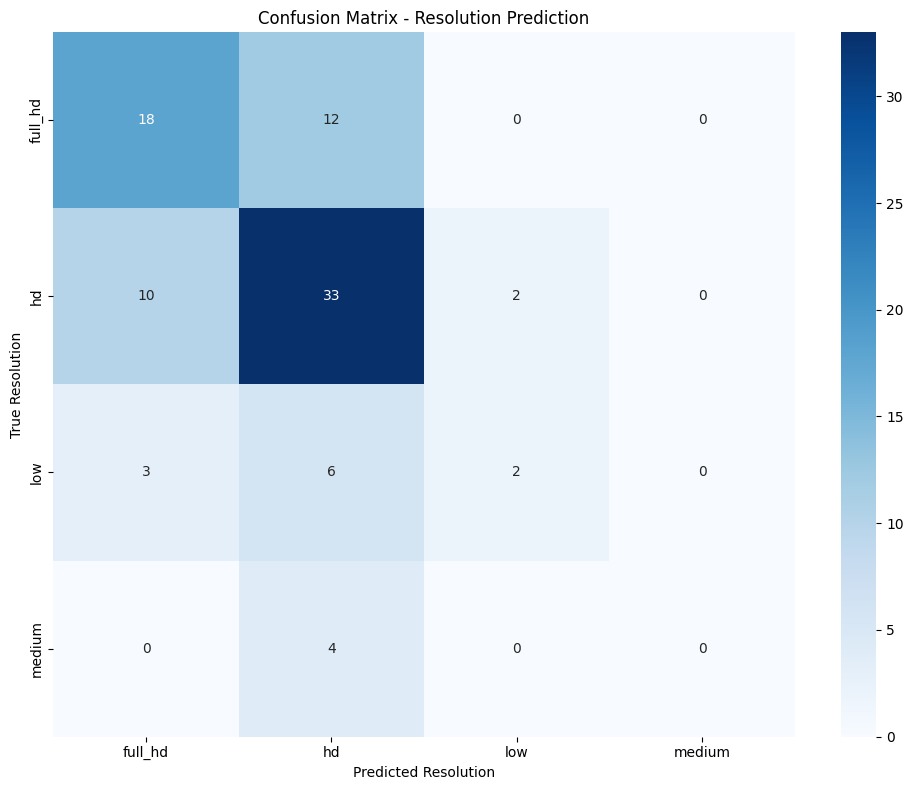

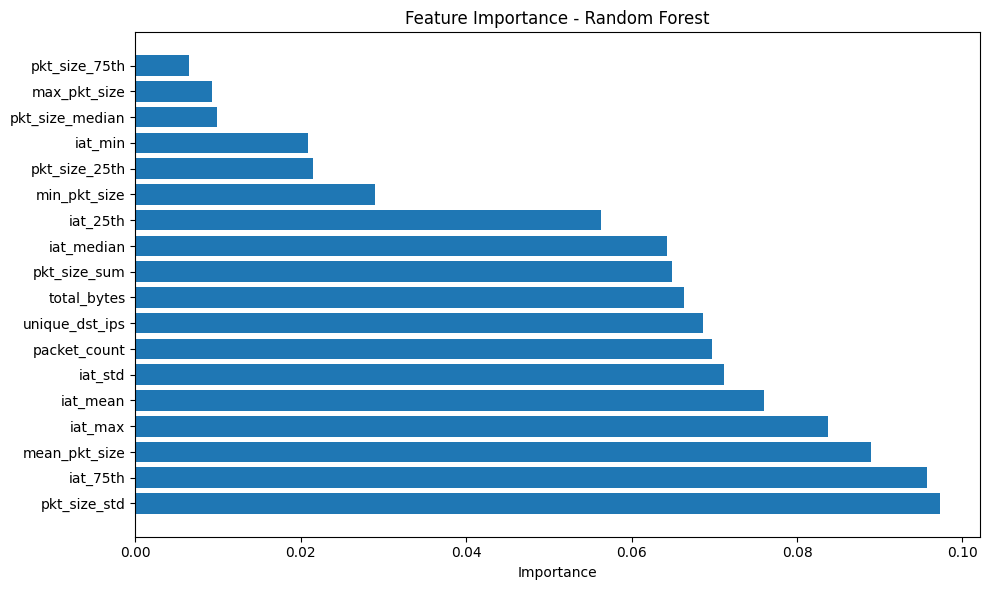

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("RANDOM FOREST - RESOLUTION PREDICTION")
print("="*60)

feature_cols = [
    # Basic packet statistics
    'packet_count',
    'total_bytes',
    'mean_pkt_size',
    'max_pkt_size',
    'min_pkt_size',
    'pkt_size_std',
    'pkt_size_median',
    'pkt_size_sum',
    'pkt_size_25th',
    'pkt_size_75th',
    
    # Inter-arrival time statistics
    'iat_min',
    'iat_max',
    'iat_mean',
    'iat_std',
    'iat_median',
    'iat_25th',
    'iat_75th',
    
    # Network diversity
    'unique_dst_ips'
]

X = nflx_flows_joined[feature_cols]
y = nflx_flows_joined['resolution']

# Handle any NaN values in features
X = X.fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
# ==============================
# Group resolutions into broader categories to improve model performance
# Not enough samples for low resolutions to train effectively
# =============================
def group_resolutions(res):
    """Group resolutions into broader categories"""
    if res <= 432:
        return 'low'  # 270, 342, 432
    elif res == 540:
        return 'medium'  # 540
    elif res == 720:
        return 'hd'  # 720
    else:
        return 'full_hd'  # 1080+

y_train_grouped = y_train.apply(group_resolutions)
y_test_grouped = y_test.apply(group_resolutions)

print("\nGrouped class distribution:")
print(y_train_grouped.value_counts().sort_index())

rf_grouped = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=41,
    n_jobs=-1
)

rf_grouped.fit(X_train, y_train_grouped)
y_pred_grouped = rf_grouped.predict(X_test)


# Evaluate
print(f"\nModel Performance:")
print(f"   Accuracy: {accuracy_score(y_test_grouped, y_pred_grouped):.4f}")

print(f"\n   Classification Report:")
print(classification_report(y_test_grouped, y_pred_grouped))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_grouped.feature_importances_
}).sort_values('importance', ascending=False)

# Confusion Matrix
cm = confusion_matrix(y_test_grouped, y_pred_grouped)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test_grouped.unique()), 
            yticklabels=sorted(y_test_grouped.unique()))
plt.title('Confusion Matrix - Resolution Prediction')
plt.ylabel('True Resolution')
plt.xlabel('Predicted Resolution')
plt.tight_layout()
plt.show()

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In conclusion, we see that our model has performed worse than the baseline model of simply dropping NaN values. This must be because we are basically squaring our error rate when we predict as predicting window size might be wrong, which is then exacerbated by the model which tries to predict QoE. 